# Project Steps
 ## Main Steps:

* Camera calibration and distortion correction.
* Color/gradient threshold.
* Perspective transform.
* Detect lane lines.

## Extra Step:
* Determine the lane curvature.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from PIL import Image
%matplotlib inline

# Camera Calibration  and Distortion Correction

In [2]:
def cameraCalibrate(image):
    # Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    import glob

    #read in and make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')

    #Arrays to store objects points and image points from all the images
    objpoints = [] #3d points
    imgpoints = [] #2d points

    #prepare points
    objp  = np.zeros((9*6,3),np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)


    for fname in images:
        #read in each image
        img = mpimg.imread(fname)
        #convert image to gray scale  
        gray  = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        #find corners  
        ret,corners = cv2.findChessboardCorners(gray,(9,6),None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
    shape =(img.shape[1],img.shape[0])
    ret, mtx, dist, rvect, tvect = cv2.calibrateCamera(objpoints,imgpoints,shape,None,None)
    
    #undistored the image
    undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)
    return undistorted_image

# Load Images

In [3]:
task_images =[]
for filename in glob.glob('./test_images/straight_lines*.jpg'):
    im=mpimg.imread(filename)
    task_images.append(im)

for filename in glob.glob('./test_images/test*.jpg'):
    im=mpimg.imread(filename)
    task_images.append(im)
    

cal_imgs = []

for im in task_images:
#    ax1.set_title('Original image', fontsize=20)
#    ax1.imshow(im)
    cim = cameraCalibrate(im)
    cal_imgs.append(cim)
#    ax2.set_title('calibrated image', fontsize=20)
#    ax2.imshow(cim)
    
#ax2.imshow(cameraCalibrate(task_images[3]))

# Gradient / Color Threshold

In [11]:
def color_and_gradient_threshold(img):

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

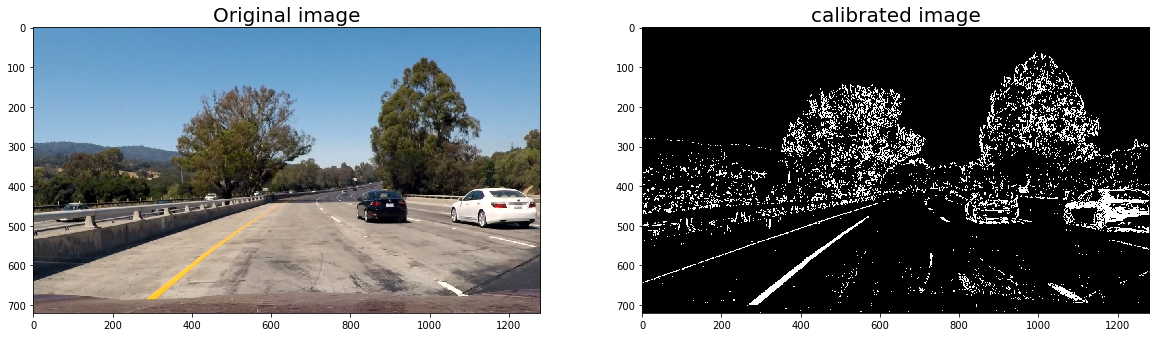

In [12]:
th_imgs = []

for im in cal_imgs:
    th_im = color_and_gradient_threshold(im)
    th_imgs.append(th_im)
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,10))  
ax1.set_title('Original image', fontsize=20)
ax1.imshow(task_images[5])
ax2.set_title('calibrated image', fontsize=20)
ax2.imshow(th_imgs[5], cmap='gray')

# Perspective Transform

In [13]:
def warped(img, top_right, top_left, bottom_right, bottom_left, flag=0):

    #extract image dimensions
    img_size = (img.shape[1], img.shape[0])
    #set source points
    src = np.float32([[top_right],[top_left],[bottom_right],[bottom_left]])
    #define width and height
    w, h = img.shape[1], img.shape[0]
    #set destination points
    dst = np.float32([[w,0],[0,0],[w,h],[0,h]])
    # get a perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # get inverse matrix
    Minv = cv2.getPerspectiveTransform(dst, src)
    # warp original image
    if(flag==1):
        return cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

In [14]:
def perspective_transform(image, flag=0):

    top_right = (725, 455) 
    top_left = (555, 455) 
    bottom_right = (1280, 680) 
    bottom_left = (0, 680)

#     trans_imgs = []
#     minvs = []
#     for im in th_imgs:
#         trans_im, minv  = warped(image, top_right, top_left, botom_right, botom_left)
#         trans_imgs.append(trans_im)
#         minvs.append(min)

    trans_im  = warped(image, top_right, top_left, bottom_right, bottom_left, flag)
    return trans_im

# f, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,10))  
# ax1.set_title('Original image', fontsize=20)
# ax1.imshow(task_images[0])
# ax2.set_title('calibrated image', fontsize=20)
# ax2.imshow(trans_imgs[0], cmap='gray')


# All Together

In [15]:
def Calc_Histogram(orig_img, threshold_img):
    # Creating Histogram
    binary_img = perspective_transform(threshold_img,0)
    original_img = orig_img
    histogram = np.sum(binary_img[int(binary_img.shape[0]/2):,:], axis=0)
          # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_img, binary_img, binary_img))*255

    # Created histogram. Need to find peaks
    midpoint = np.int(histogram.shape[0]/2)
    left_peak = np.argmax(histogram[:midpoint])
    right_peak = np.argmax(histogram[midpoint:]) + midpoint
    
    return binary_img, out_img, left_peak, right_peak





def sliding_window(orig_img, binary_img, out_img, left_peak, right_peak, W_Number = 9, Margin= 100, Minimum_pixels = 50, Window_Height=10):
    Window_Height = np.int(binary_img.shape[0]/W_Number)
    left_pixels = []
    right_pixels = []
    curr_left = left_peak
    curr_right = right_peak
    pixels = binary_img.nonzero()
    pixels_y = np.array(pixels[0])
    pixels_x = np.array(pixels[1])
    
    for window in range(W_Number):
        # Find window dimensions
        winy_bot = binary_img.shape[0] - (window+1)*Window_Height
        winy_top = binary_img.shape[0] - window*Window_Height
        winx_left_min = curr_left - Margin
        winx_left_max = curr_left + Margin
        winx_right_min = curr_right - Margin
        winx_right_max = curr_right + Margin
        
        cv2.rectangle(out_img,(winx_left_min,winy_bot),(winx_left_max,winy_top),(0,255,0), 2) 
        cv2.rectangle(out_img,(winx_right_min,winy_bot),(winx_right_max,winy_top),(0,255,0), 2) 
          
        white_pixels_left = ((pixels_y >= winy_bot) & (pixels_y < winy_top) & (pixels_x >= winx_left_min) & (pixels_x < winx_left_max)).nonzero()[0]
        white_pixels_right = ((pixels_y >= winy_bot) & (pixels_y < winy_top) & (pixels_x >= winx_right_min) & (pixels_x < winx_right_max)).nonzero()[0]
        
        left_pixels.append(white_pixels_left)
        right_pixels.append(white_pixels_right)
        
        if(len(white_pixels_left)>Minimum_pixels):
            curr_left = np.int(np.mean(pixels[1][white_pixels_left]))
        if(len(white_pixels_right)>Minimum_pixels):
            curr_right = np.int(np.mean(pixels[1][white_pixels_right]))
        
    left_pixels= np.concatenate(left_pixels)
    right_pixels= np.concatenate(right_pixels)

    left_x = pixels_x[left_pixels]
    left_y = pixels_y[left_pixels]
    right_x = pixels_x[right_pixels]
    right_y = pixels_y[right_pixels]
    
    left_polyfit = []
    right_polyfit = []
    if len(left_x) > 0:
          left_polyfit = np.polyfit(left_y, left_x, 2)

    if len(right_x) > 0:
          right_polyfit = np.polyfit(right_y, right_x, 2)
    
    out_img[pixels_y[left_pixels], pixels_x[left_pixels]] = [255, 0, 0]
    out_img[pixels_y[right_pixels], pixels_x[right_pixels]] = [0, 0, 255]

    plot_y = np.linspace(0, binary_img.shape[0]-1, binary_img.shape[0] )
    
    return out_img, left_polyfit, right_polyfit, left_y, left_x, right_y, right_x, plot_y 
        




# Detect Lane Lines

After finishing the previous steps You now have a thresholded warped image and you're ready to map out the lane lines! There are many ways you could go about this, but here's one example of how you might do it:
### Peaks in a Histogram and Sliding Windows
* After applying calibration, thresholding, and a perspective transform to a road image, you should have a binary image where the lane lines stand out clearly. However, you still need to decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line.
* we can use the two highest peaks from our histogram as a starting point for determining where the lane lines are, and then use sliding windows moving upward in the image (further along the road) to determine where the lane lines go.
#### steps:
  1. split the histogram into two sides, one for each lane line.
  2. Set up sliding windows and window hyperparameters:
     * set a few hyperparameters related to our sliding windows, and set them up to iterate across the binary activations in the image. These hyperparameters are:
        1. **W_Number**; number of sliding windows.
        2. **Margin**; the width of each window.
        3. **Minimum_pixels**; used as a threshold to recenter the next sliding window.
        4. **Window_Height**; computed from number of pixels and image height.
  3. Loop through each window in W_Number.
  4. Find the boundaries of our current window. This is based on a combination of the current window's starting point      , as well as the margin you set in the hyperparameters.
  5. Use cv2.rectangle to draw these window boundaries onto visualization image.
  6. Now that we know the boundaries of our window, find out which activated(non zero) pixels actually fall into the window.
  7. Append these non zero pixels to two different arrays one for the right line and the other for the left line.
  8. If the number of pixels you found in Step **6** are greater than your hyperparameter Minimum_pixels, re-center our window based on the mean position of these pixels.
  9. Now that we have found all our pixels belonging to each line through the sliding window method, it's time to fit a polynomial to the line.

## This function is to draw back the lane on the original image
**N.B.** Add an inverse option in the perspective function so that we can transform the image back to it's original perspective. This can be implemented by swapping **src** and **dst** in cv2.getPerspectiveTransform(src, dst) when a certain flag is set to 1.

In [16]:
#draw lane
# left_fit and right_fit generated from step 9 in lane Detection
# bird_eye the image after thresholding and perspective transform
# read the inverse note below in the code
def draw_lane(img,bird_eye,left_fit,right_fit):
    tmp_image     = np.copy(img)
    if right_fit is None or left_fit is None:
        return img
    
    zero          = np.zeros_like(bird_eye).astype(np.uint8)
    layered_image = np.dstack((zero,zero,zero))
    
    ploty      = np.linspace(0, bird_eye.shape[0]-1, bird_eye.shape[0] )
    left_fitx  = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] 
    
    #formatting the points
    left   = np.array([np.transpose(np.vstack([right_fitx,ploty]))])
    right  = np.array([np.flipud(np.transpose(np.vstack([left_fitx,ploty])))])
    points = np.hstack((left,right))
    
    #form lane
    cv2.fillPoly(layered_image,np.int_([points]),(0,255,0))
    cv2.polylines(layered_image,np.int32([right]),isClosed = False,color=(255,0,0),thickness = 20)
    cv2.polylines(layered_image,np.int32([left]),isClosed = False,color=(255,0,0),thickness = 20)
    
    # The inverse perspective transfom note
    # use the inverse perspective option mentioned in the note above to transform back the layered_image
    inversed = perspective_transform(layered_image,1)
    output   = cv2.addWeighted(tmp_image,1,inversed,0.5,0)
    return output

## Determine The Lane Curvature
You're getting very close to a final result! You have a thresholded image, where you've estimated which pixels belong to the left and right lane lines, and you've fit a polynomial to those pixel positions. Next we'll compute the radius of curvature of the fit.

## Curvature in Pixels
In the last step we computed the lane line pixels using their x and y pixel positions to fit a second order polynomial curve: $$f(y) = Ay^2+By+C $$
in this step you will compute the radius of curvature at the closest point to the vehicle.

**Radius of Curvature Equation:**
$$R\_Curve = \frac{[1+(\frac{dx}{dy})^2]^{3/2}}{|\frac{d^2x}{dy^2}|}$$

$$f'(y) = \frac{dx}{dy} = 2Ay+B$$

$$f''(y) = \frac{d^2x}{dy^2} =A$$

## From Pixels to Real World
* Great! You've now calculated the radius of curvature for our lane lines. But now we need to stop and think... We've calculated the radius of curvature based on pixel values, so the radius we are reporting is in pixel space, which is not the same as real world space. So we actually need to repeat this calculation after converting our x and y values to real world space.

* This involves measuring how long and wide the section of lane is that we're projecting in our warped image. We could do this in detail by measuring out the physical lane in the field of view of the camera, but for this project, you can assume that if you're projecting a section of lane similar to the images above, the lane is about 30 meters long and 3.7 meters wide.

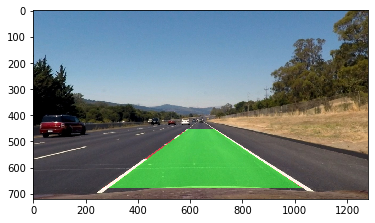

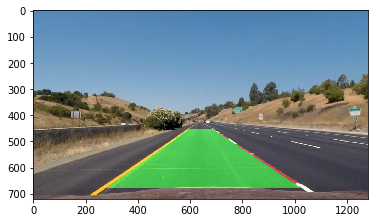

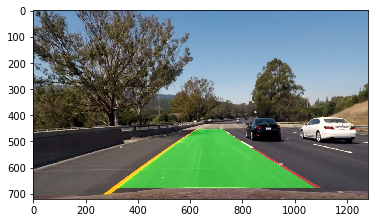

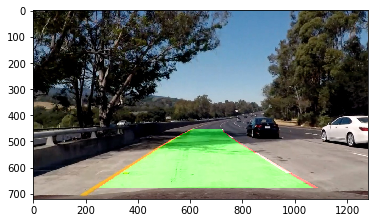

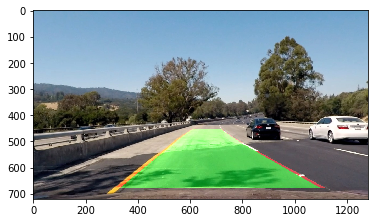

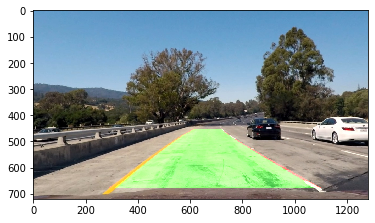

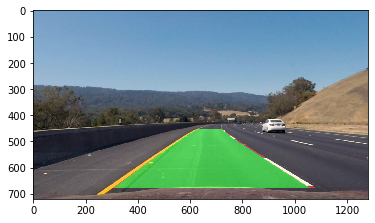

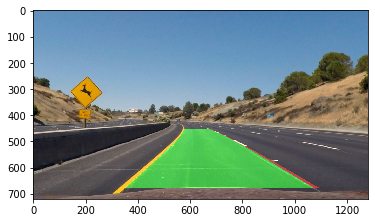

In [18]:
for i in range(len(th_imgs)):
    orig_img = cal_imgs[i]
    threshold_img = th_imgs[i]
    
    binary_img, out_img, left_peak, right_peak = Calc_Histogram(orig_img, threshold_img)
    new_out, left_polyfit, right_polyfit, left_y, left_x, right_y, right_x, plot_y  = sliding_window(orig_img, binary_img, out_img, left_peak, right_peak)
    output = draw_lane(orig_img ,binary_img, left_polyfit, right_polyfit)
    plt.figure()
    plt.imshow(output)